In [1]:
import tensorflow as tf

CONTENT_FILES = './input/clp/long'
STYLE_FILES = './input/laplus/long'

windowSize = 72         # the input width of the model
vecLen = 128            # length of vector generated by siamese vector
shape = 24              # length of time axis of split specrograms to feed to generator            

batch_size = 16         #batch size



# Reading

In [2]:

from MelGAN.processing import sampleRate, wav2spectrum
from utils import loadFile
from glob import glob
import numpy as np


def loadData(path):
    files = glob(f'{path}/*.wav')
    data = []
    for file in files:
        x = loadFile(file, sampleRate)
        data.append(x)
    print(f'loaded {len(files)} files from {path}')
    return data

def transformData(Xs):
    ret = []
    for x in Xs:
        ret.append(wav2spectrum(x)[:, :, None])
    return ret

def splitCut(data):
    ret = []
    mini = 0
    miniFinal = 10 * shape
    for i in range(len(data) - 1):
        mini = min(data[i].shape[1], data[i + 1].shape[1])
        if mini >= windowSize and mini < miniFinal:
            miniFinal = mini
    for i in range(len(data)):
        x = data[i]
        if x.shape[1] >= windowSize:
            for n in range(x.shape[1] // miniFinal):
                ret.append(x[:, n * miniFinal: n * miniFinal + miniFinal, :])
            ret.append(x[:, -miniFinal:, :])
    return np.array(ret)


# Read waveform
x_content = loadData(CONTENT_FILES)
x_style = loadData(STYLE_FILES)

# Transform into spectrum
a_content = transformData(x_content)
a_style = transformData(x_style)

# Split spectrumgrams in chunks with equal size
data_content = splitCut(a_content)
data_style = splitCut(a_style)


print(f'sampleRate: {sampleRate}')


loaded 1 files from ./input/clp/long
loaded 1 files from ./input/laplus/long
sampleRate: 16000


# Making Dataset

In [35]:

from MelGAN.processing import hop

@tf.function
def proc(x):
    return tf.image.random_crop(x, size = [hop, windowSize, 1])

dsa = tf.data.Dataset.from_tensor_slices(data_content).repeat(200).map(proc, num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(10000).batch(batch_size, drop_remainder = True)
dsb = tf.data.Dataset.from_tensor_slices(data_style).repeat(200).map(proc, num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(10000).batch(batch_size, drop_remainder = True)

print(f'Load {len(dsa)} samples')

Load 11175 samples


# Training scheme

In [25]:

from MelGAN.processing import sampleRate, wav2spectrum, spectrum2wav
from tensorflow.keras.layers import Concatenate, Cropping2D
import matplotlib.pyplot as plt
from utils import writeFile
from MelGAN.models import *
from MelGAN.loss import *
import IPython
import time



def crop(x):
    x1 = Cropping2D(((0, 0), (0, 2 * (x.shape[2] // 3))))(x)
    x2 = Cropping2D(((0, 0), (x.shape[2] // 3, x.shape[2] // 3)))(x)
    x3 = Cropping2D(((0, 0), (2 * (x.shape[2] // 3), 0)))(x)
    return x1, x2, x3

def assemble_image(x1, x2, x3):
    x = Concatenate(2)([x1, x2, x3])
    return x


@tf.function
def train_all(x, y):

    x1, x2, x3 = crop(x)
    y1, y2, y3 = crop(y)

    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

        gen_x_1 = model_G(x1, training = True)
        gen_x_2 = model_G(x2, training = True)
        gen_x_3 = model_G(x3, training = True)

        gen_y_1 = model_G(y1, training = True)
        gen_y_2 = model_G(y2, training = True)
        gen_y_3 = model_G(y3, training = True)


        gen = assemble_image(gen_x_1, gen_x_2, gen_x_3)

        iden_gen = model_D(gen, training = True)
        iden_ori = model_D(y, training = True)

        siam_x_1_gen = model_S(gen_x_1, training = True)
        siam_x_2_gen = model_S(gen_x_3, training = True)

        siam_x_1 = model_S(x1, training = True)
        siam_x_2 = model_S(x3, training = True)

        loss_id = (mae(y1, gen_y_1) + mae(y2, gen_y_2) + mae(y3, gen_y_3)) / 3.0

        loss_m = loss_travel(siam_x_1, siam_x_1_gen, siam_x_2, siam_x_2_gen)  + loss_siamese(siam_x_1, siam_x_2, delta)

        loss_g = g_loss_f(iden_gen)
        loss_dr = d_loss_r(iden_ori)
        loss_df = d_loss_f(iden_gen)
        loss_d = (loss_dr + loss_df) / 2.0

        loss_total = loss_g + 10.0 * loss_m + 10.0 * loss_id

    grad_gen = tape_gen.gradient(loss_total, model_G.trainable_variables + model_S.trainable_variables)
    opt_gen.apply_gradients(zip(grad_gen, model_G.trainable_variables + model_S.trainable_variables))

    grad_disc = tape_disc.gradient(loss_d, model_D.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, model_D.trainable_variables))

    return loss_dr, loss_df, loss_g, loss_id

# Train Critic only
tf.function
def train_d(x, y):

    x1, x2, x3 = crop(x)
    
    with tf.GradientTape() as tape_disc:
        
        gen_x_1 = model_G(x1, training = True)
        gen_x_2 = model_G(x2, training = True)
        gen_x_3 = model_G(x3, training = True)

        gen = assemble_image(gen_x_1, gen_x_2, gen_x_3)

        iden_gen = model_D(gen, training = True)
        iden_ori = model_D(y, training = True)

        loss_dr = d_loss_r(iden_ori)
        loss_df = d_loss_f(iden_gen)
        loss_d = (loss_dr + loss_df) / 2.0

    grad_disc = tape_disc.gradient(loss_d, model_D.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, model_D.trainable_variables))

    return loss_dr, loss_df

# Set learning rate
def update_lr(lr):
    opt_gen.learning_rate = lr
    opt_disc.learning_rate = lr

def train(epochs, lr = 0.0001, n_save = 3, gupt = 3):

    update_lr(lr)

    losses = {
        'loss_id': [],
        'loss_dr': [],
        'loss_df': [],
        'loss_g': []
    }

    df_list = []
    dr_list = []
    g_list = []
    id_list = []

    c = 0
    g = 0

    for epoch in range(1, max_epochs):
        
        loss_g_epoch = 0.0
        loss_id_epoch = 0.0
        loss_dr_epoch = 0.0
        loss_df_epoch = 0.0

        bef = time.time()
        for batchi, (x, y) in enumerate(zip(dsa, dsb)):

            if batchi % gupt == 0:
                dloss_t, dloss_f, gloss, idloss = train_all(x, y)
                
                loss_dr_epoch += dloss_t
                loss_df_epoch += dloss_f
                loss_id_epoch += idloss
                loss_g_epoch += gloss

            else:
                dloss_t, dloss_f = train_d(x, y)

                loss_dr_epoch += dloss_t
                loss_df_epoch += dloss_f


            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)

            c += 1
            g += 1

            if batchi % 600 == 0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis = 0)} ', end = '')
                print(f'r: {np.mean(dr_list[-g:], axis = 0)}] ', end = '')
                print(f'[G loss: {np.mean(g_list[-g:], axis = 0)}] ', end = '')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end = '')
                print(f'[LR: {lr}]')

                g = 0
            nbatch = batchi

        # save training info 
        losses['loss_g'].append(loss_g_epoch)
        losses['loss_id'].append(loss_id_epoch)
        losses['loss_dr'].append(loss_dr_epoch)
        losses['loss_df'].append(loss_df_epoch)

        print(f'Time/Batch {(time.time() - bef) / nbatch}')
        print(f'Mean D loss: {np.mean(df_list[-c:], axis = 0)} Mean G loss: {np.mean(g_list[-c:], axis = 0)} Mean ID loss: {np.mean(id_list[-c:], axis = 0)}')
        c = 0

        if epoch % n_save == 0:

            epoch_path = os.path.join(saved_experiment_path, f'epoch_{epoch}')

            if not os.path.exists(epoch_path):
                os.mkdir(epoch_path)

            if os.path.exists(test_waveform_file):
                
                x_input = loadFile(test_waveform_file, sampleRate)

                S_input = wav2spectrum(x_input)

                H, W = S_input.shape
                S_output = np.zeros((H, W))

                for i in range(0, W - shape, shape):
                    S_output[:, i: i + shape] = np.array(model_G(S_input[:, i: i + shape].reshape(1, hop, shape, 1), training = False)).squeeze()

                S_output[:, -shape:] = np.array(model_G(S_input[: , -shape:].reshape(1, hop, shape, 1), training = False)).squeeze()


                x_output = spectrum2wav(S_output)

                # save generated waveform
                writeFile(os.path.join(epoch_path, 'ori.wav'), x_input, sampleRate)
                writeFile(os.path.join(epoch_path, 'gen.wav'), x_output, sampleRate)


                if plot_spec:
                    IPython.display.display(IPython.display.Audio(np.squeeze(x_output), rate=sampleRate))
                    IPython.display.display(IPython.display.Audio(np.squeeze(x_input), rate=sampleRate))
                    fig, axs = plt.subplots(ncols = 2)
                    axs[0].imshow(np.flip(S_input, -2), cmap = None)
                    axs[0].axis('off')
                    axs[0].set_title('Source')
                    axs[1].imshow(np.flip(S_output, -2), cmap = None)
                    axs[1].axis('off')
                    axs[1].set_title('Generated')
                    plt.show()

                model_S.save_weights(os.path.join(epoch_path, 'siam.h5'))
                model_G.save_weights(os.path.join(epoch_path, 'gen.h5'))
                model_D.save_weights(os.path.join(epoch_path, 'critic.h5'))

                print(f'Save model and generate waveform at epoch {epoch}')

    return losses


# Settings

In [36]:

learning_rate = 0.00001
# learning_rate_G = 0.00001
# learning_rate_D = 0.000005


delta = 2.0


max_epochs = 5      # maximum epochs

load_model_path = './saved_model/clptolapus_3/epoch_4'  # path of the pretrained model
saved_experiment_path = './saved_model/clptolapus_4'   # path of the saved model
test_waveform_file = './input/clp/short/clp_test.wav'

if not os.path.exists(saved_experiment_path):
    os.mkdir(saved_experiment_path)

    
plot_spec = True    # plot spectrum when training 
saved_epoch = 1      # save model period

pretrained =True   # If loading the pretrained model 



# Train

[Epoch 1/5] [Batch 0] [D loss f: 0.45425352454185486 r: 0.12152206897735596] [G loss: 0.5457465052604675] [ID loss: 0.09685217589139938] [LR: 1e-05]
[Epoch 1/5] [Batch 600] [D loss f: 0.09674529731273651 r: 0.11672041565179825] [G loss: 0.9337140917778015] [ID loss: 0.10274938493967056] [LR: 1e-05]
[Epoch 1/5] [Batch 1200] [D loss f: 0.07654393464326859 r: 0.09521500021219254] [G loss: 0.9455859661102295] [ID loss: 0.10283511877059937] [LR: 1e-05]
[Epoch 1/5] [Batch 1800] [D loss f: 0.07512124627828598 r: 0.0991009995341301] [G loss: 0.9516194462776184] [ID loss: 0.10240864753723145] [LR: 1e-05]
[Epoch 1/5] [Batch 2400] [D loss f: 0.07430891692638397 r: 0.10491783171892166] [G loss: 0.9305991530418396] [ID loss: 0.10182246565818787] [LR: 1e-05]
[Epoch 1/5] [Batch 3000] [D loss f: 0.07723594456911087 r: 0.10080695152282715] [G loss: 0.9305981397628784] [ID loss: 0.10157527774572372] [LR: 1e-05]
[Epoch 1/5] [Batch 3600] [D loss f: 0.07780949771404266 r: 0.10490996390581131] [G loss: 0.91

100%|██████████| 2000/2000 [01:05<00:00, 30.65it/s, loss=0.0651, spectral_convergence=-15.7]


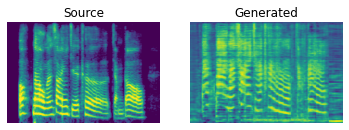

Save model and generate waveform at epoch 1
[Epoch 2/5] [Batch 0] [D loss f: 0.0993400290608406 r: 0.10613356530666351] [G loss: 0.861839234828949] [ID loss: 0.09725919365882874] [LR: 1e-05]
[Epoch 2/5] [Batch 600] [D loss f: 0.08411450684070587 r: 0.11600474268198013] [G loss: 0.8826859593391418] [ID loss: 0.09740237891674042] [LR: 1e-05]
[Epoch 2/5] [Batch 1200] [D loss f: 0.08331192284822464 r: 0.11847343295812607] [G loss: 0.8992262482643127] [ID loss: 0.09785874933004379] [LR: 1e-05]
[Epoch 2/5] [Batch 1800] [D loss f: 0.07992828637361526 r: 0.11789095401763916] [G loss: 0.896718442440033] [ID loss: 0.09639039635658264] [LR: 1e-05]
[Epoch 2/5] [Batch 2400] [D loss f: 0.08667878806591034 r: 0.11911946535110474] [G loss: 0.8795953392982483] [ID loss: 0.09667724370956421] [LR: 1e-05]
[Epoch 2/5] [Batch 3000] [D loss f: 0.08853732794523239 r: 0.12110872566699982] [G loss: 0.886481523513794] [ID loss: 0.0973973199725151] [LR: 1e-05]
[Epoch 2/5] [Batch 3600] [D loss f: 0.079901345074176

100%|██████████| 2000/2000 [00:54<00:00, 36.91it/s, loss=0.0654, spectral_convergence=-15.7]


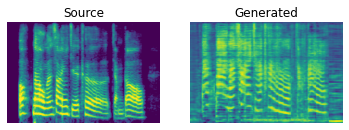

Save model and generate waveform at epoch 2
[Epoch 3/5] [Batch 0] [D loss f: 0.09832194447517395 r: 0.12752610445022583] [G loss: 0.9838334321975708] [ID loss: 0.0956161692738533] [LR: 1e-05]
[Epoch 3/5] [Batch 600] [D loss f: 0.08539465069770813 r: 0.13122932612895966] [G loss: 0.8997877240180969] [ID loss: 0.09577818959951401] [LR: 1e-05]
[Epoch 3/5] [Batch 1200] [D loss f: 0.08095493167638779 r: 0.12823842465877533] [G loss: 0.8878438472747803] [ID loss: 0.0952826663851738] [LR: 1e-05]
[Epoch 3/5] [Batch 1800] [D loss f: 0.08228802680969238 r: 0.12868118286132812] [G loss: 0.8895747661590576] [ID loss: 0.09379900246858597] [LR: 1e-05]
[Epoch 3/5] [Batch 2400] [D loss f: 0.08486105501651764 r: 0.12831363081932068] [G loss: 0.9026409983634949] [ID loss: 0.094427689909935] [LR: 1e-05]
[Epoch 3/5] [Batch 3000] [D loss f: 0.08089669048786163 r: 0.12055496126413345] [G loss: 0.9046695828437805] [ID loss: 0.09328242391347885] [LR: 1e-05]
[Epoch 3/5] [Batch 3600] [D loss f: 0.08851014077663

: 

: 

In [37]:

from tensorflow.keras.optimizers import Adam
import pickle as pkl


if pretrained:
    model_S, model_G, model_D = load(load_model_path, hop, shape, vecLen)
else:
    model_S, model_G, model_D = build(hop, shape, vecLen)


opt_gen = Adam(learning_rate, 0.5)
opt_disc = Adam(learning_rate, 0.5)

losses = train(max_epochs, lr = learning_rate, n_save = saved_epoch, gupt = 3)


info = {
    'loss': losses,
    'epochs': max_epochs,
    'learning_rate': learning_rate,
    'input_shape': (hop, windowSize, 1),
    'vecLen': vecLen,
    'batch_size': batch_size,
    'saved_model_path': saved_experiment_path,
    'load_model_path': load_model_path,
    'pretrained': pretrained
}

with open(os.path.join(saved_experiment_path, 'train_info.pkl'), 'wb') as f:
    pkl.dump(info, f)

model_S.save_weights(os.path.join(saved_experiment_path, 'siam.h5'))
model_G.save_weights(os.path.join(saved_experiment_path, 'gen.h5'))
model_D.save_weights(os.path.join(saved_experiment_path, 'critic.h5'))


# Show training process

In [ ]:

from utils import plot_curve
# print(losses['loss_g'])

# print(losses['loss_df'])

# total_loss = np.array(losses['loss_S']) + np.array(losses['loss_G']) + np.array(losses['loss_D'])
print(losses.keys())
# plot_curve(losses['loss_D'], losses['loss_G'], total_loss, 'Critic loss', 'Generator loss ', 'Total loss', False)
# plot_curve(losses['loss_g'])
# print(losses['loss_m'])
# print(losses['loss_g'])
# print(losses['loss_GS'])




# Load Model

In [ ]:
from MelGAN.models import *

model_S, model_G, model_D = load(load_model_path, hop, shape, vecLen)


# Generate output

In [ ]:

from MelGAN.processing import wav2spectrum, spectrum2wav 
from utils import loadFile, writeFile


INPUT_FILE = './input/clp/short/clp_test.wav'





In [18]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

[Epoch 0/5000] [Batch 0] [D loss f: 0.946246862411499 r: 1.0393058061599731] [G loss: 0.053753096610307693] [ID loss: 0.4505717158317566] [LR: 0.0002]
[Epoch 0/5000] [Batch 600] [D loss f: 0.10516137629747391 r: 0.09587658941745758] [G loss: 1.8864717483520508] [ID loss: 0.2502760589122772] [LR: 0.0002]
[Epoch 0/5000] [Batch 1200] [D loss f: 0.16592755913734436 r: 0.14238785207271576] [G loss: 1.761867642402649] [ID loss: 0.1753253936767578] [LR: 0.0002]
[Epoch 0/5000] [Batch 1800] [D loss f: 0.18400339782238007 r: 0.16668444871902466] [G loss: 1.3841091394424438] [ID loss: 0.17986981570720673] [LR: 0.0002]
[Epoch 0/5000] [Batch 2400] [D loss f: 0.22198334336280823 r: 0.1671149879693985] [G loss: 1.2561800479888916] [ID loss: 0.19175522029399872] [LR: 0.0002]
[Epoch 0/5000] [Batch 3000] [D loss f: 0.24284809827804565 r: 0.1871901899576187] [G loss: 1.120714545249939] [ID loss: 0.2090461254119873] [LR: 0.0002]
[Epoch 0/5000] [Batch 3600] [D loss f: 0.2762352526187897 r: 0.20423859357833

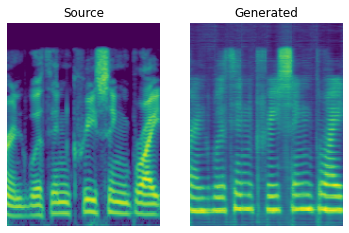

Mean D loss: 0.2556450366973877 Mean G loss: 1.0938233137130737 Mean ID loss: 0.21674774587154388
[Epoch 1/5000] [Batch 0] [D loss f: 0.25840163230895996 r: 0.20706228911876678] [G loss: 0.9584484696388245] [ID loss: 0.18467813730239868] [LR: 0.0002]
[Epoch 1/5000] [Batch 600] [D loss f: 0.27654582262039185 r: 0.2391919493675232] [G loss: 0.9718177318572998] [ID loss: 0.17296326160430908] [LR: 0.0002]
[Epoch 1/5000] [Batch 1200] [D loss f: 0.3018025755882263 r: 0.2584629952907562] [G loss: 1.0408903360366821] [ID loss: 0.16055534780025482] [LR: 0.0002]
[Epoch 1/5000] [Batch 1800] [D loss f: 0.31185558438301086 r: 0.27867966890335083] [G loss: 1.0084179639816284] [ID loss: 0.15016551315784454] [LR: 0.0002]
[Epoch 1/5000] [Batch 2400] [D loss f: 0.3216381371021271 r: 0.3190353512763977] [G loss: 0.932697057723999] [ID loss: 0.13794060051441193] [LR: 0.0002]
[Epoch 1/5000] [Batch 3000] [D loss f: 0.3374548554420471 r: 0.3496527671813965] [G loss: 1.0077956914901733] [ID loss: 0.1290631741

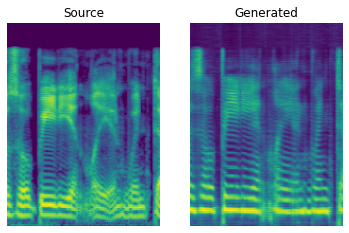

Mean D loss: 0.3724028170108795 Mean G loss: 0.9456859230995178 Mean ID loss: 0.13310497999191284
[Epoch 2/5000] [Batch 0] [D loss f: 0.40323761105537415 r: 0.5023263096809387] [G loss: 0.9534997344017029] [ID loss: 0.1241522952914238] [LR: 0.0002]
[Epoch 2/5000] [Batch 600] [D loss f: 0.4149301052093506 r: 0.5038473606109619] [G loss: 0.9215171337127686] [ID loss: 0.1219845563173294] [LR: 0.0002]
[Epoch 2/5000] [Batch 1200] [D loss f: 0.4283885657787323 r: 0.4967641234397888] [G loss: 0.8857417702674866] [ID loss: 0.12150935083627701] [LR: 0.0002]
[Epoch 2/5000] [Batch 1800] [D loss f: 0.4198015034198761 r: 0.506611704826355] [G loss: 0.7957383990287781] [ID loss: 0.12073865532875061] [LR: 0.0002]
[Epoch 2/5000] [Batch 2400] [D loss f: 0.4141125977039337 r: 0.5134508013725281] [G loss: 0.8071987628936768] [ID loss: 0.12040071934461594] [LR: 0.0002]
[Epoch 2/5000] [Batch 3000] [D loss f: 0.4294365346431732 r: 0.5082582831382751] [G loss: 0.8438205122947693] [ID loss: 0.119711734354496]

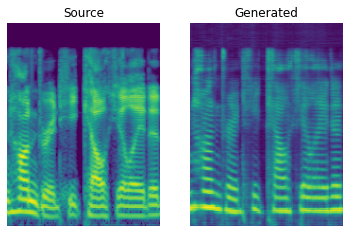

Mean D loss: 0.4434609115123749 Mean G loss: 0.8061758875846863 Mean ID loss: 0.11786165833473206
[Epoch 3/5000] [Batch 0] [D loss f: 0.47157496213912964 r: 0.5440727472305298] [G loss: 0.7534793615341187] [ID loss: 0.11411206424236298] [LR: 0.0002]
[Epoch 3/5000] [Batch 600] [D loss f: 0.46728515625 r: 0.5417335033416748] [G loss: 0.7300180792808533] [ID loss: 0.11441083252429962] [LR: 0.0002]
[Epoch 3/5000] [Batch 1200] [D loss f: 0.47584453225135803 r: 0.5362666249275208] [G loss: 0.8305720090866089] [ID loss: 0.11427274346351624] [LR: 0.0002]
[Epoch 3/5000] [Batch 1800] [D loss f: 0.4788101613521576 r: 0.5454729199409485] [G loss: 0.7988753318786621] [ID loss: 0.11373786628246307] [LR: 0.0002]
[Epoch 3/5000] [Batch 2400] [D loss f: 0.4813511073589325 r: 0.5406832098960876] [G loss: 0.7483606338500977] [ID loss: 0.11347178369760513] [LR: 0.0002]
[Epoch 3/5000] [Batch 3000] [D loss f: 0.4772970676422119 r: 0.5395640134811401] [G loss: 0.7866873145103455] [ID loss: 0.11247766017913818

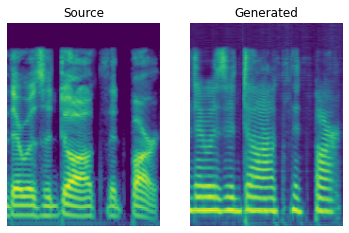

Mean D loss: 0.48636502027511597 Mean G loss: 0.7300953269004822 Mean ID loss: 0.11230944097042084
[Epoch 4/5000] [Batch 0] [D loss f: 0.48885688185691833 r: 0.5571128726005554] [G loss: 0.7132313251495361] [ID loss: 0.11004157364368439] [LR: 0.0002]
[Epoch 4/5000] [Batch 600] [D loss f: 0.5055797100067139 r: 0.5672678351402283] [G loss: 0.6735538840293884] [ID loss: 0.11047408729791641] [LR: 0.0002]
[Epoch 4/5000] [Batch 1200] [D loss f: 0.5073981881141663 r: 0.562495231628418] [G loss: 0.7467396855354309] [ID loss: 0.11084772646427155] [LR: 0.0002]
[Epoch 4/5000] [Batch 1800] [D loss f: 0.49762287735939026 r: 0.5560131072998047] [G loss: 0.7127503752708435] [ID loss: 0.11072225123643875] [LR: 0.0002]
[Epoch 4/5000] [Batch 2400] [D loss f: 0.496694952249527 r: 0.5642803907394409] [G loss: 0.7013402581214905] [ID loss: 0.11030235141515732] [LR: 0.0002]
[Epoch 4/5000] [Batch 3000] [D loss f: 0.5184606313705444 r: 0.5671107769012451] [G loss: 0.7023600339889526] [ID loss: 0.1094849556684

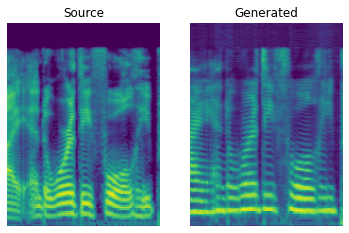

Mean D loss: 0.5123541355133057 Mean G loss: 0.6907634139060974 Mean ID loss: 0.10904466360807419
[Epoch 5/5000] [Batch 0] [D loss f: 0.5263499617576599 r: 0.5739243030548096] [G loss: 0.6329571604728699] [ID loss: 0.10749097913503647] [LR: 0.0002]
[Epoch 5/5000] [Batch 600] [D loss f: 0.526710033416748 r: 0.5751768350601196] [G loss: 0.704848051071167] [ID loss: 0.10806312412023544] [LR: 0.0002]
[Epoch 5/5000] [Batch 1200] [D loss f: 0.5284450054168701 r: 0.5798521637916565] [G loss: 0.6866737008094788] [ID loss: 0.10726498812437057] [LR: 0.0002]
[Epoch 5/5000] [Batch 1800] [D loss f: 0.5163319110870361 r: 0.5784767866134644] [G loss: 0.6325944066047668] [ID loss: 0.10767000913619995] [LR: 0.0002]
[Epoch 5/5000] [Batch 2400] [D loss f: 0.5103586912155151 r: 0.5918506979942322] [G loss: 0.6991329193115234] [ID loss: 0.1073475107550621] [LR: 0.0002]
[Epoch 5/5000] [Batch 3000] [D loss f: 0.5216537714004517 r: 0.5888093113899231] [G loss: 0.6511713266372681] [ID loss: 0.10765442252159119

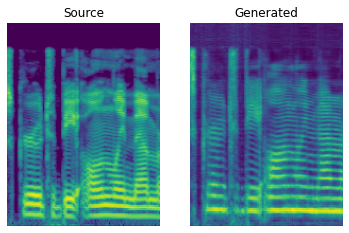

Mean D loss: 0.5271177291870117 Mean G loss: 0.6695885062217712 Mean ID loss: 0.10668869316577911
[Epoch 6/5000] [Batch 0] [D loss f: 0.5344256162643433 r: 0.5856717228889465] [G loss: 0.7292916178703308] [ID loss: 0.1063515841960907] [LR: 0.0002]
[Epoch 6/5000] [Batch 600] [D loss f: 0.5308448076248169 r: 0.5990174412727356] [G loss: 0.6687183976173401] [ID loss: 0.10587585717439651] [LR: 0.0002]
[Epoch 6/5000] [Batch 1200] [D loss f: 0.5354537963867188 r: 0.5983219146728516] [G loss: 0.6912484765052795] [ID loss: 0.10520720481872559] [LR: 0.0002]
[Epoch 6/5000] [Batch 1800] [D loss f: 0.5426607728004456 r: 0.5879239439964294] [G loss: 0.6681267023086548] [ID loss: 0.10576529055833817] [LR: 0.0002]
[Epoch 6/5000] [Batch 2400] [D loss f: 0.5309639573097229 r: 0.6034961938858032] [G loss: 0.5957290530204773] [ID loss: 0.10546170920133591] [LR: 0.0002]
[Epoch 6/5000] [Batch 3000] [D loss f: 0.5242474675178528 r: 0.6011607050895691] [G loss: 0.5958366990089417] [ID loss: 0.105383999645709

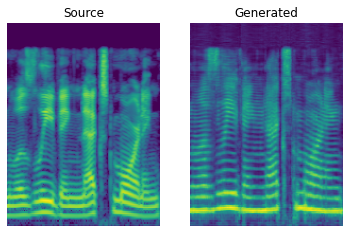

Mean D loss: 0.5330089330673218 Mean G loss: 0.6422443985939026 Mean ID loss: 0.10470607131719589
[Epoch 7/5000] [Batch 0] [D loss f: 0.5229377746582031 r: 0.6117292046546936] [G loss: 0.5500667095184326] [ID loss: 0.10401271283626556] [LR: 0.0002]
[Epoch 7/5000] [Batch 600] [D loss f: 0.5334239602088928 r: 0.6167933940887451] [G loss: 0.7195210456848145] [ID loss: 0.10347199440002441] [LR: 0.0002]
[Epoch 7/5000] [Batch 1200] [D loss f: 0.5354273319244385 r: 0.6119921803474426] [G loss: 0.6230868101119995] [ID loss: 0.10336010158061981] [LR: 0.0002]
[Epoch 7/5000] [Batch 1800] [D loss f: 0.52910315990448 r: 0.6137889623641968] [G loss: 0.624853253364563] [ID loss: 0.10318896919488907] [LR: 0.0002]
[Epoch 7/5000] [Batch 2400] [D loss f: 0.5335327386856079 r: 0.611939013004303] [G loss: 0.595643937587738] [ID loss: 0.10347150266170502] [LR: 0.0002]
[Epoch 7/5000] [Batch 3000] [D loss f: 0.542760968208313 r: 0.6153147220611572] [G loss: 0.667902410030365] [ID loss: 0.10298539698123932] [L

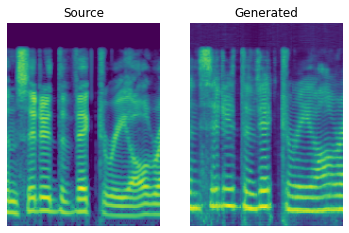

Mean D loss: 0.5399014949798584 Mean G loss: 0.6419997215270996 Mean ID loss: 0.10276667028665543
[Epoch 8/5000] [Batch 0] [D loss f: 0.5441985726356506 r: 0.6172634363174438] [G loss: 0.6977824568748474] [ID loss: 0.1023908481001854] [LR: 0.0002]
[Epoch 8/5000] [Batch 600] [D loss f: 0.5413464307785034 r: 0.6151762008666992] [G loss: 0.5870065093040466] [ID loss: 0.10236699134111404] [LR: 0.0002]
[Epoch 8/5000] [Batch 1200] [D loss f: 0.540265679359436 r: 0.6191569566726685] [G loss: 0.6405388116836548] [ID loss: 0.10207715630531311] [LR: 0.0002]
[Epoch 8/5000] [Batch 1800] [D loss f: 0.5364211797714233 r: 0.6244168281555176] [G loss: 0.5780001878738403] [ID loss: 0.10174912214279175] [LR: 0.0002]
[Epoch 8/5000] [Batch 2400] [D loss f: 0.5334169864654541 r: 0.6218811869621277] [G loss: 0.6314342021942139] [ID loss: 0.10173537582159042] [LR: 0.0002]
[Epoch 8/5000] [Batch 3000] [D loss f: 0.5431346297264099 r: 0.6147294640541077] [G loss: 0.6049832701683044] [ID loss: 0.1015654802322387

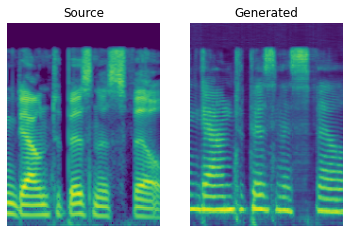

Mean D loss: 0.540183424949646 Mean G loss: 0.6170722842216492 Mean ID loss: 0.10137024521827698
[Epoch 9/5000] [Batch 0] [D loss f: 0.5423597097396851 r: 0.6324273943901062] [G loss: 0.603736937046051] [ID loss: 0.10151779651641846] [LR: 0.0002]
[Epoch 9/5000] [Batch 600] [D loss f: 0.5484394431114197 r: 0.6264597773551941] [G loss: 0.6767461895942688] [ID loss: 0.10095302015542984] [LR: 0.0002]
[Epoch 9/5000] [Batch 1200] [D loss f: 0.5356792211532593 r: 0.6372596025466919] [G loss: 0.5752258896827698] [ID loss: 0.10090167075395584] [LR: 0.0002]
[Epoch 9/5000] [Batch 1800] [D loss f: 0.5404490828514099 r: 0.630379855632782] [G loss: 0.6385523080825806] [ID loss: 0.10102277994155884] [LR: 0.0002]
[Epoch 9/5000] [Batch 2400] [D loss f: 0.5576601028442383 r: 0.6252186298370361] [G loss: 0.6402767896652222] [ID loss: 0.10061639547348022] [LR: 0.0002]
[Epoch 9/5000] [Batch 3000] [D loss f: 0.5423558354377747 r: 0.6282506585121155] [G loss: 0.5894648432731628] [ID loss: 0.10053751617670059

KeyboardInterrupt: 

In [50]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

train(5000, batch_size = bs, lr = 0.0002, n_save = 1, gupt = 3)